In [1]:
!pip install pandas matplotlib seaborn numpy pyspark

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

In [3]:
# Créer une session Spark
spark = SparkSession.builder.appName("Projet2_RegressionLineaire").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/23 17:02:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Charger les données du fichier csv dans un dataframe
df = spark.read.csv("gold1.csv", header=True, inferSchema=True)

In [12]:
# Afficher le schéma du dataframe
print("======= Schéma ====== \n")
df.printSchema()

# Afficher un résumé statistique des colonnes du dataframe
print("======= Résumé Statistique ====== \n")
df.describe().show()
df.count()

# Afficher les 5 premières lignes du dataframe
print("======= 5 premières lignes ====== \n")
df.show(5)

# Afficher le nombre de valeurs manquantes dans chaque colonne
print("======= Nombre de Valeures Nulles ====== \n")
df.select([f.sum(f.col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()
#df = df.na.drop() # supprime les lignes avec des valeurs manquantes dans le dataframe (pas besoin pour notre dataset)

# Afficher le nombre duplicatas dans le dataframe
lignes_dupliquees = df.groupby(df.columns).agg(f.count("*").alias("compte")).filter("compte > 1") # récupère toutes les lignes dupliquées
lignes_dupliquees = lignes_dupliquees.withColumn('nb_duplicatas', f.col("compte") - 1) # ajoute une colonne qui compte le nombre de duplicatas pour chaque ligne (on soustrait 1 car il y a une ligne qui faudra garder pour chaque groupe de duplicatas)
print("======= Nombre de doublons ====== \n")
lignes_dupliquees.select(f.sum("nb_duplicatas").alias("nb_total_duplicatas")).show()
#df = df.dropDuplicates() # supprime les duplicatas dans le dataframe (pas besoin pour notre dataset)

# Convertir la colonne Date de type date en un format numérique (timestamp)
df = df.withColumn("Date_Timestamp",df["Date"].cast("Date"))
df = df.withColumn("Date_Timestamp",f.unix_timestamp(df["Date_Timestamp"]))
df = df.withColumn("Close",df["Close"])

======= Schéma ====== 

root
 |-- _c0: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Date_Timestamp: long (nullable = true)

======= Résumé Statistique ====== 



24/11/23 18:27:40 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Date, Close, Volume, Open, High, Low
 Schema: _c0, Date, Close, Volume, Open, High, Low
Expected: _c0 but found: 
CSV file: file:///media/C/Vincent/Documents/École/UQO%20Automne%202024/Introduction%20à%20la%20science%20des%20données/Projet_2_Analyse_Salaires/Science_donn-es_2/gold1.csv


+-------+------------------+------------------+-----------------+------------------+------------------+------------------+--------------------+
|summary|               _c0|             Close|           Volume|              Open|              High|               Low|      Date_Timestamp|
+-------+------------------+------------------+-----------------+------------------+------------------+------------------+--------------------+
|  count|              2511|              2511|             2511|              2511|              2511|              2511|                2511|
|   mean|1260.7929111907606|1498.7260852250076| 185970.770609319|1498.7255276782168|1508.4514536041315|1488.8699322978953|1.5477257548387096E9|
| stddev|  729.262879035108|298.82481071452435|97600.76938172727| 299.1181873664931|  301.262244334454|296.41770317733733| 9.107488719609354E7|
|    min|                 0|            1049.6|              1.0|            1051.5|            1062.7|            1045.4|          1390

24/11/23 18:27:40 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Date, Close, Volume, Open, High, Low
 Schema: _c0, Date, Close, Volume, Open, High, Low
Expected: _c0 but found: 
CSV file: file:///media/C/Vincent/Documents/École/UQO%20Automne%202024/Introduction%20à%20la%20science%20des%20données/Projet_2_Analyse_Salaires/Science_donn-es_2/gold1.csv
24/11/23 18:27:40 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Date, Close, Volume, Open, High, Low
 Schema: _c0, Date, Close, Volume, Open, High, Low
Expected: _c0 but found: 
CSV file: file:///media/C/Vincent/Documents/École/UQO%20Automne%202024/Introduction%20à%20la%20science%20des%20données/Projet_2_Analyse_Salaires/Science_donn-es_2/gold1.csv


+---+----+-----+------+----+----+---+--------------+
|_c0|Date|Close|Volume|Open|High|Low|Date_Timestamp|
+---+----+-----+------+----+----+---+--------------+
|  0|   0|    0|     0|   0|   0|  0|             0|
+---+----+-----+------+----+----+---+--------------+

======= Nombre de doublons ====== 

+-------------------+
|nb_total_duplicatas|
+-------------------+
|               NULL|
+-------------------+



24/11/23 18:27:40 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Date, Close, Volume, Open, High, Low
 Schema: _c0, Date, Close, Volume, Open, High, Low
Expected: _c0 but found: 
CSV file: file:///media/C/Vincent/Documents/École/UQO%20Automne%202024/Introduction%20à%20la%20science%20des%20données/Projet_2_Analyse_Salaires/Science_donn-es_2/gold1.csv


24/11/23 18:27:55 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Date, Close, Volume, Open, High, Low
 Schema: _c0, Date, Close, Volume, Open, High, Low
Expected: _c0 but found: 
CSV file: file:///media/C/Vincent/Documents/École/UQO%20Automne%202024/Introduction%20à%20la%20science%20des%20données/Projet_2_Analyse_Salaires/Science_donn-es_2/gold1.csv


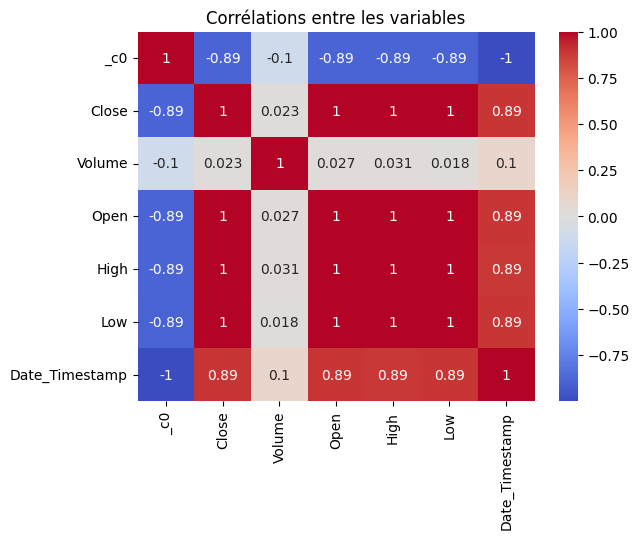

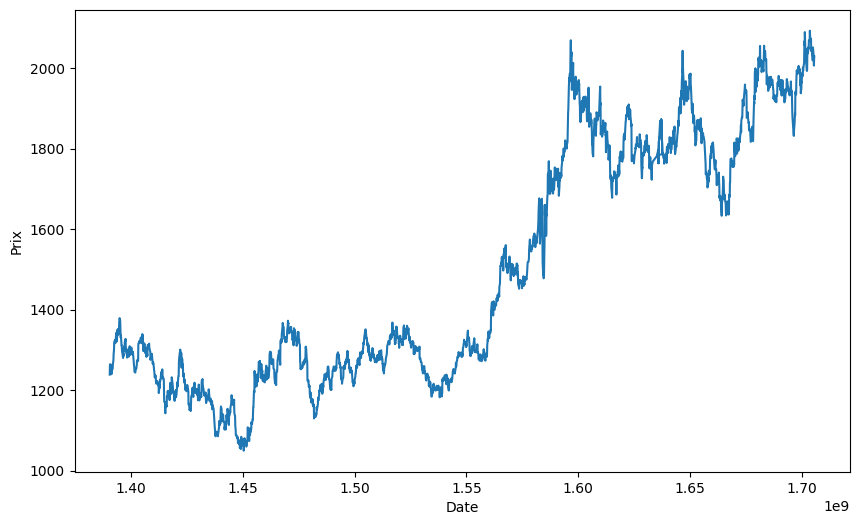

In [13]:
# Convertir le dataframe pyspark en dataframe pandas pour la visualisation
df_pandas = df.toPandas()

# Créer une matrice des corrélations entre les variables
df_pandas_donnees_numeriques = df_pandas.select_dtypes(include=["number"])
matrice_de_correlations = df_pandas_donnees_numeriques.corr()
sns.heatmap(matrice_de_correlations, annot=True, cmap='coolwarm')
plt.title('Corrélations entre les variables')
plt.show()

# Créer un graphique Prix selon Date (lineplot)
plt.figure(figsize=(10,6))
plt.plot(df_pandas["Date_Timestamp"], df_pandas["Close"])
plt.xlabel("Date")
plt.ylabel("Prix")
plt.show()

In [14]:
# Préparation des données pour le modèle
assembler = VectorAssembler(inputCols=["Date_Timestamp"], outputCol="features")
data_ready = assembler.transform(df).select("features", "Close").withColumnRenamed("Close", "label")

# Diviser les données du dataframe en données d'entrainement (80%) et de test (20%)
train_data, test_data = data_ready.randomSplit([0.8,0.2],seed=5)

# Créer un modèle de régression linéaire et l'entrainer avec les données d'entrainement
lr = LinearRegression(featuresCol="features",labelCol="label")
lr_model = lr.fit(train_data)

# Effectuer des prédictions avec les données de test 
test_predictions = lr_model.transform(test_data)
test_predictions.select("features","label","prediction").show()

24/11/23 18:29:13 WARN Instrumentation: [1321273b] regParam is zero, which might cause numerical instability and overfitting.


+-------------+------+------------------+
|     features| label|        prediction|
+-------------+------+------------------+
|[1.3911444E9]|1239.8|1046.2183200079294|
|[1.3935636E9]|1321.6|1053.2497547873054|
|[1.3941684E9]|1338.2|1055.0076134821497|
|[1.3958064E9]|1303.4|1059.7684807806854|
|[1.3964112E9]|1290.8|1061.5263394755298|
|[1.3971024E9]|1320.5|1063.5353208410656|
|[1.3971888E9]|1319.0|1063.7864435117576|
|[1.3976208E9]|1303.5| 1065.042056865218|
|[1.3983984E9]|1300.8|1067.3021609014459|
|[1.3986576E9]|1299.0|1068.0555289135218|
|[1.3990032E9]|1302.9|1069.0600195962902|
| [1.399608E9]|1287.6| 1070.817878291134|
|[1.3998672E9]|1295.8|  1071.57124630321|
|[1.4012496E9]|1259.7|1075.5892090342822|
| [1.401336E9]|1257.1|1075.8403317049742|
|[1.4019408E9]|1253.3|1077.5981903998186|
|[1.4020272E9]|1252.5|1077.8493130705106|
| [1.402632E9]|1274.1|1079.6071717653545|
| [1.403496E9]|1318.4|1082.1183984722747|
|[1.4041008E9]|1322.0|1083.8762571671186|
+-------------+------+------------

In [15]:
# Calculer les métriques d'évaluation du modèle
test_evaluation = lr_model.evaluate(test_data)
print("==================== Résultats ====================")
print(".")
print("Erreur quadratique moyenne (MSE)",test_evaluation.meanSquaredError)
print("Erreur absolue moyenne (MAE)", test_evaluation.meanAbsoluteError)
print("Coefficient de Détermination (R2)", test_evaluation.r2)
print("===================================================")


==================== Résultats ====================
.
Erreur quadratique moyenne (MSE) 17343.90180211225
Erreur absolue moyenne (MAE) 107.65161754239925
Coefficient de Détermination (R2) 0.8044231818794929


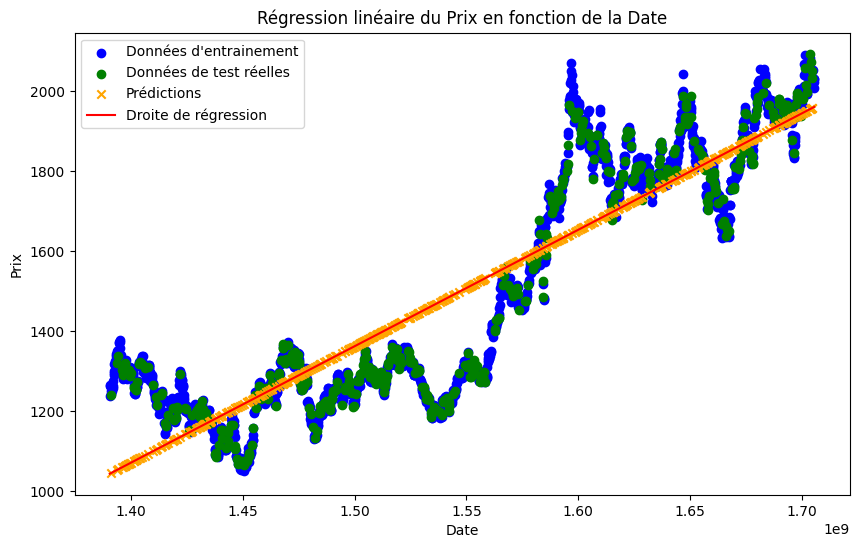

In [16]:
# Transformer les données d'entrainement et de test sous format panda
resultats_entrainement_pandas = train_data.select("features","label").toPandas()
resultats_test_pandas = test_predictions.select("features","label", "prediction").toPandas()

# Extraire les dates (timestamp)
resultats_entrainement_pandas["Date_Timestamp"] = resultats_entrainement_pandas["features"].apply(lambda x: x[0])
resultats_test_pandas["Date_Timestamp"] = resultats_test_pandas["features"].apply(lambda x: x[0])

# Créer le graphique pour visualiser les résultats
plt.figure(figsize=(10,6))

plt.scatter(resultats_entrainement_pandas["Date_Timestamp"], resultats_entrainement_pandas["label"], color='blue', label = "Données d'entrainement")
plt.scatter(resultats_test_pandas["Date_Timestamp"],resultats_test_pandas["label"], color="green", label = "Données de test réelles")
plt.scatter(resultats_test_pandas["Date_Timestamp"], resultats_test_pandas["prediction"], color="orange", marker="x", label="Prédictions")

x_line = np.linspace(df.select("Date_Timestamp").rdd.min()[0],df.select("Date_Timestamp").rdd.max()[0], 100)
y_line = lr_model.coefficients[0] * x_line + lr_model.intercept

plt.plot(x_line,y_line, color = "red",label= "Droite de régression")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.title("Régression linéaire du Prix en fonction de la Date")
plt.legend()
plt.show() 